# Homework 1 - Deep Learning Winter 2024
TA: Jerry Abu Ayoub

<font color='aqua'>
Student 1: Or Dinar 207035809
</font>
<br>
<font color='aqua'>
Student 2: Ramiz Srour 314855446
</font>

## Libraries and Drive

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The following command would only work after going to the shared folder on google drive -> right-click -> organize -> add shortcut

In [ ]:
%cd drive/MyDrive/DeepLearning

/content/drive/MyDrive/DeepLearning


In [ ]:
%cd drive/MyDrive/HW1

In [ ]:
!ls

colums.txt  part1_test.csv  part1_train.csv


## Exercise 1 - Income Prediction

### Data visualiztion and pre processing

> Loading the training and testing data into dataframes

In [ ]:
df_train = pd.read_csv('part1_train.csv', header=None)
df_test = pd.read_csv('part1_test.csv', header=None)

df_train = df_train[~df_train.apply(lambda row: row.astype(str).str.contains(r'\?', na=False)).any(axis=1)]
df_test = df_test[~df_test.apply(lambda row: row.astype(str).str.contains(r'\?', na=False)).any(axis=1)]

> Giving columns readable names - using the file 'colums.txt' attached with the exercise.

In [ ]:
with open('colums.txt', 'r') as file:
    lines = file.readlines()

column_names = []
for index, line in enumerate(lines):
    if index == 14:        # Output line
        column_name = 'Output'
    else:
        column_name = line.split(':')[0].strip()
    column_names.append(column_name)

df_train.columns = column_names
df_test.columns = column_names

In [ ]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


> Observing the distribution of the incomes

#### Visualization

In [ ]:
income_counts = df_train['Output'].value_counts()

print("Income Distribution:")
print(f'Above 50k: {income_counts.iloc[0]}')
print(f'Below 50k: {income_counts.iloc[1]}')

Income Distribution:
Above 50k: 22654
Below 50k: 7508


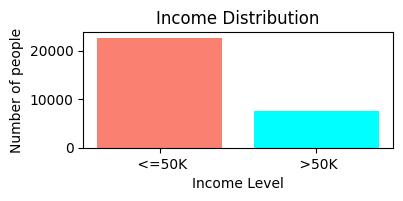

In [ ]:
plt.figure(figsize=(4, 1.5))

plt.bar(income_counts.index, income_counts.values, color=['salmon', 'aqua'])

plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('Number of people')

plt.show()

#### Pre Processing
Assigning numerical values to strings in the data

In [ ]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
label_encoder = LabelEncoder()

for col in categorical_columns:
    df_train[col] = label_encoder.fit_transform(df_train[col])
    df_test[col] = label_encoder.transform(df_test[col])

Scaling continous data using standard deviation

In [ ]:
continuous_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = StandardScaler()

df_train[continuous_columns] = scaler.fit_transform(df_train[continuous_columns])
df_test[continuous_columns] = scaler.transform(df_test[continuous_columns])

> Assigning binary values to the outputs.

>> Output | Value
>> --- | ---
>> '<=50K' | 0
>> '>50K' | 1

In [ ]:
possible_outputs_train = df_train['Output'].unique()
possible_outputs_test = df_test['Output'].unique()

df_train['Output'] = df_train['Output'].apply(lambda x: 0 if x == possible_outputs_train[0] else 1)
df_test['Output'] = df_test['Output'].apply(lambda x: 0 if x == possible_outputs_test[0] else 1)

In [ ]:
print(f"Preprocessed training dataframe")
df_train.head()

Preprocessed training dataframe


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Output
0,0.042796,5,-1.062722,9,1.128918,4,0,1,4,1,0.146092,-0.218586,-0.077734,38,0
1,0.880288,4,-1.007871,9,1.128918,2,3,0,4,1,-0.147445,-0.218586,-2.331531,38,0
2,-0.033340,2,0.244693,11,-0.439738,0,5,1,4,1,-0.147445,-0.218586,-0.077734,38,0
3,1.108695,2,0.425240,1,-1.224066,2,5,0,2,1,-0.147445,-0.218586,-0.077734,38,0
4,-0.794697,2,1.406658,9,1.128918,2,9,5,2,0,-0.147445,-0.218586,-0.077734,4,0


> Placing the data in tensors.

In [ ]:
X_train = df_train.drop('Output', axis=1).values
y_train = df_train['Output'].values
X_test = df_test.drop('Output', axis=1).values
y_test = df_test['Output'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=21, stratify=y_train
)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

### Model Definition

The model consists of:
> Layer | Input Size | Output Size | Activation
> --- | --- | --- | ---
> Fully Connected 1 | 14 | 512 |	Leaky ReLU
> BatchNorm 1| 512 |	512 |	-
> Dropout 1 |	512 |	512 |	-
> Fully Connected 2 |	512 |	256 |	Leaky ReLU
> Dropout 2 |	256 |	256 |	-
> Fully Connected 3 | 256 | 128 |	Leaky ReLU
> BatchNorm 2| 128 |	128 |	-
> Dropout 3 |	128 |	128 |	-
> Fully Connected 4 | 128 | 64 |	Leaky ReLU
> Fully Connected 5 | 64 | 32 |	Leaky ReLU
> BatchNorm 3| 32 |	32 |	-
> Dropout 4 |	32 |	32 |	-
> Fully Connected 6 | 32 | 1 |	-

In [ ]:
class IncomePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(IncomePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)

        self.fc5 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.fc6 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc3(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.bn3(self.fc5(x)))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

input_size = X_train.shape[1]
model = IncomePredictionModel(input_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [ ]:
print(model)

IncomePredictionModel(
  (fc1): Linear(in_features=14, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


The model has 183,617 trainable parameters.

Input - FC1: $$ 14 \cdot 512 + 512 = 7680$$
FC1 - BN1: $$ 512 \cdot 2 = 1024$$
BN1 - FC2: $$ 512 \cdot 256 + 256 = 131328$$
FC2 - FC3: $$ 256 \cdot 128 + 128 = 32896$$
FC3 - BN2: $$ 128 \cdot 2 = 256$$
BN2 - FC4: $$ 128 \cdot 64 + 64 = 8256$$
FC4 - FC5: $$ 64 \cdot 32 + 32 = 2080$$
FC5 - BN3: $$ 32 \cdot 2 = 64$$
BN3 - FC6: $$ 32 \cdot 1 + 1 = 33$$
<br>
<font color='aqua'>
$$ TOTAL-PARAMATERS=183,617 $$
</font>

We decided to utilize Binary Cross-Entropy log loss since this task requires us to classify samples.
<br>
The optimizer we used is adam since it performs well for most tasks. The learning rate we used is 0.001 with weight decay (L2 Regularization) of 0.001.

#### Training and Testing

In [ ]:
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, scheduler=None, patience=7, num_epochs=100):
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predictions = (outputs >= 0.5).float()
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)  # Store training accuracy

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val.float())
            val_predictions = (val_outputs >= 0.5).float()
            val_accuracy = (val_predictions == y_val).float().mean()

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}")

        if scheduler:
            scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping!")
                break

    return model, train_losses, val_losses, val_accuracies, train_accuracies


In [ ]:
model, train_losses, val_losses, val_accuracies, train_accuracies = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val)

Epoch [1/100], Train Loss: 0.6733, Train Accuracy: 0.7315, Val Loss: 0.6692, Val Accuracy: 0.7762
Epoch [2/100], Train Loss: 0.5637, Train Accuracy: 0.7842, Val Loss: 0.5338, Val Accuracy: 0.8155
Epoch [3/100], Train Loss: 0.4995, Train Accuracy: 0.8127, Val Loss: 0.4588, Val Accuracy: 0.8270
Epoch [4/100], Train Loss: 0.4582, Train Accuracy: 0.8205, Val Loss: 0.4296, Val Accuracy: 0.8321
Epoch [5/100], Train Loss: 0.4287, Train Accuracy: 0.8230, Val Loss: 0.4056, Val Accuracy: 0.8276
Epoch [6/100], Train Loss: 0.4088, Train Accuracy: 0.8206, Val Loss: 0.3973, Val Accuracy: 0.8346
Epoch [7/100], Train Loss: 0.3953, Train Accuracy: 0.8247, Val Loss: 0.3837, Val Accuracy: 0.8356
Epoch [8/100], Train Loss: 0.3832, Train Accuracy: 0.8277, Val Loss: 0.3842, Val Accuracy: 0.8381
Epoch [9/100], Train Loss: 0.3763, Train Accuracy: 0.8273, Val Loss: 0.3745, Val Accuracy: 0.8367
Epoch [10/100], Train Loss: 0.3734, Train Accuracy: 0.8285, Val Loss: 0.3745, Val Accuracy: 0.8341
Epoch [11/100], Tra

Text(0.5, 1.0, 'Loss vs. Epochs')

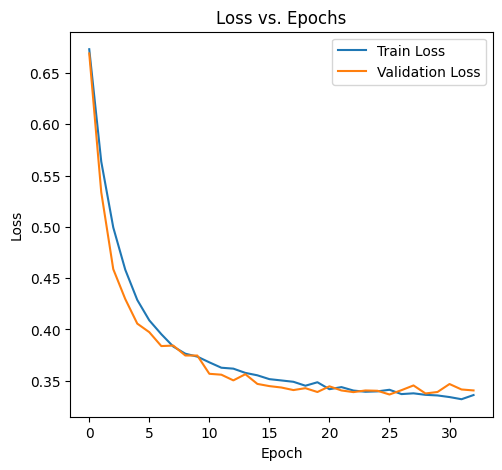

In [78]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

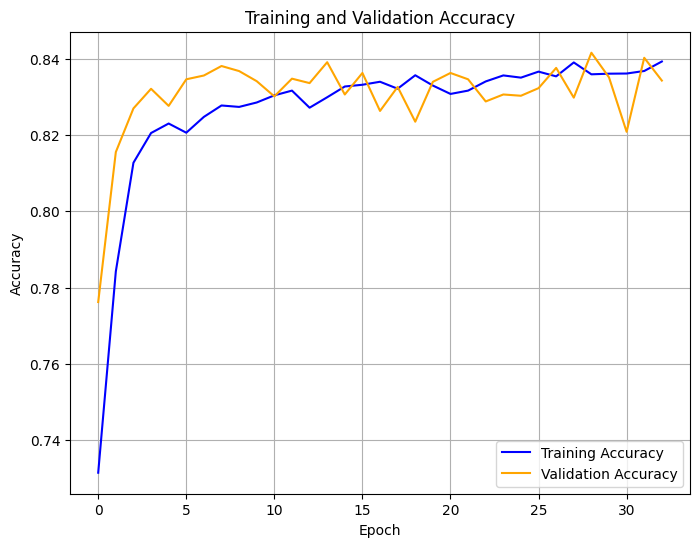

In [80]:
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test).squeeze()
    test_predictions = (test_outputs >= 0.5).float()
    test_accuracy = (test_predictions == y_test).float().mean()
    print(f"Test Accuracy: {test_accuracy.item() * 100:.2f}%")

Test Accuracy: 83.65%


## Network Summary

__Fully Connected Layers__

The model utilizes 6 FC layers where the number of neurons decreases:<br>
input_size → 512 → 256 → 128 → 64 → 32 → 1

__Batch Normalization Layers__

Batch normalization layers are applied after some FC layers to normalize activatins in order to achieve convergence faster.

__Leaky Relu Activations__

We decided to introduce non-linmearity into the model by using the Leaky-ReLU activation function.

__Dropout Layers__

The model also utilizes Dropout layers where p = 0.5 in order to generalize better.

__Early Stopping__

We implemented an early stoping mechanism that stops the training process after 7 consecutive epohcs that yield a worse result than the best result so far in the training.

## Exercise 2 - Network 1

Importing necessary libraries

In [ ]:
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from torchsummary import summary

Downloaded the required data, and transformed the images for a data type which is suitable for inserting in PyTorch tensors.
Filtered both train and test dataset out of the images whose labels are not the first 4 categories. [0-4]
Split the training data (24,000) to 22,000 samples for training and 2000 for valiation.


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

target_classes = [0, 1, 2, 3]

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
filtered_train_dataset = [(image, label) for image, label in train_dataset if label in target_classes]

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
filtered_test_dataset = [(image, label) for image, label in test_dataset if label in target_classes]

filtered_train_dataset, filtered_validation_dataset = random_split(filtered_train_dataset, [22000, 2000])

# Example: Length of filtered datasets
print(f'Filtered Train Dataset Size: {len(filtered_train_dataset)}')
print(f'Filtered Test Dataset Size: {len(filtered_test_dataset)}')

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Filtered Train Dataset Size: 22000
Filtered Test Dataset Size: 4000


Split the training data to batches of 1500's

In [ ]:
train_loader = DataLoader(filtered_train_dataset,batch_size = 1500, shuffle=True)
print("Filtered Size = " , len(filtered_train_dataset))

Filtered Size =  22000


Built a 2-Layer NN as required, with an input size of 784, since our pictures are of dims 28x28 with size 4 in the output layer, since we are classifying only 4 classes.

In [ ]:
class FashionMNIST(nn.Module):
    def __init__(self, input_size):
        super(FashionMNIST, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)

    def forward(self, x):
        x = self.fc1(x)
        return x

model = FashionMNIST(input_size=784)
print(model)

FashionMNIST(
  (fc1): Linear(in_features=784, out_features=4, bias=True)
)


**Parameters**
This network has 784 x 4 + 4 = 3140 parameters

* Used CrossEntropyLoss as the loss function because it is the most appropriate loss function for multi-class classification. While others might work but this worked best with our problem.
* As mentioned earlier, since our images are of dims 28x28 the input size of our network is 784
* Used Adam optimizer with a learning rate of 0.001 as it involves the optimization of several deep learning optimizers like SGD, RMSProp.
Tested over several learning rates and this achieved the best.

In [ ]:
loss_values = [] # Used to store loss values to plot.
train_accuracies = [] # Used to store training accuracy to plot.
val_accuracies = [] # Used to store validation accuracy to plot.
val_losses = [] # For personal plotting and testing.

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

val_loader = DataLoader(filtered_validation_dataset, batch_size=64, shuffle=False) # Validation data loader.

num_epochs = len(train_loader) - 2  # Training over 13 Epochs
for epoch in range(num_epochs):
    model.train() # Set the model ready to training mode
    correct = 0
    total = 0
    running_loss = 0.0 # For calculating avg loss.

    # Training Loop
    for images, labels in train_loader:

        images = images.view(images.size(0), -1) # Flatten the images

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()  # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)  # Total samples in the batch
        correct += (predicted == labels).sum().item()  # Count correct predictions
        running_loss += loss.item()  # Add up the loss.

    # Calculate training accuracy and loss for the epoch
    train_accuracy = correct / total
    train_accuracies.append(correct / total)  # Append training accuracy
    loss_values.append(running_loss / len(train_loader))  # Average loss per Epoch

    # Validation Loop (during training)
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.view(val_images.size(0), -1)  # Flatten the images

            val_outputs = model(val_images) # Forward Pass
            val_loss = criterion(val_outputs, val_labels)

            _, val_predicted = torch.max(val_outputs.data, 1)  # Calculate validation predictions
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    # Calculate validation accuracy and loss for the epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss.item())  # Average validation loss per batch

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {loss_values[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')


# Test Evaluation
test_loader = DataLoader(filtered_test_dataset, batch_size=64, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)  # Flatten images

        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class

        total += labels.size(0) # Calculate accuracy
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')


Epoch [1/13], Train Loss: 1.0645, Train Accuracy: 0.6717, Val Loss: 0.6702, Val Accuracy: 0.8800
Epoch [2/13], Train Loss: 0.6201, Train Accuracy: 0.8948, Val Loss: 0.3899, Val Accuracy: 0.8895
Epoch [3/13], Train Loss: 0.4631, Train Accuracy: 0.9011, Val Loss: 0.2856, Val Accuracy: 0.8975
Epoch [4/13], Train Loss: 0.3972, Train Accuracy: 0.9050, Val Loss: 0.2348, Val Accuracy: 0.8965
Epoch [5/13], Train Loss: 0.3594, Train Accuracy: 0.9079, Val Loss: 0.2038, Val Accuracy: 0.9020
Epoch [6/13], Train Loss: 0.3346, Train Accuracy: 0.9093, Val Loss: 0.1821, Val Accuracy: 0.9045
Epoch [7/13], Train Loss: 0.3173, Train Accuracy: 0.9133, Val Loss: 0.1715, Val Accuracy: 0.9045
Epoch [8/13], Train Loss: 0.3039, Train Accuracy: 0.9153, Val Loss: 0.1568, Val Accuracy: 0.9045
Epoch [9/13], Train Loss: 0.2924, Train Accuracy: 0.9163, Val Loss: 0.1481, Val Accuracy: 0.9060
Epoch [10/13], Train Loss: 0.2842, Train Accuracy: 0.9181, Val Loss: 0.1472, Val Accuracy: 0.9100
Epoch [11/13], Train Loss: 0.

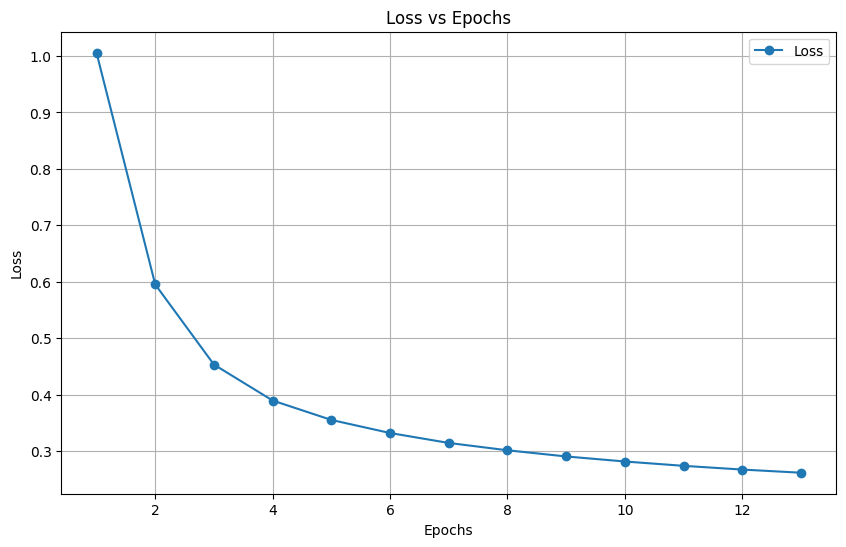

In [ ]:
epochs = range(1, len(loss_values) + 1)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', label="Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

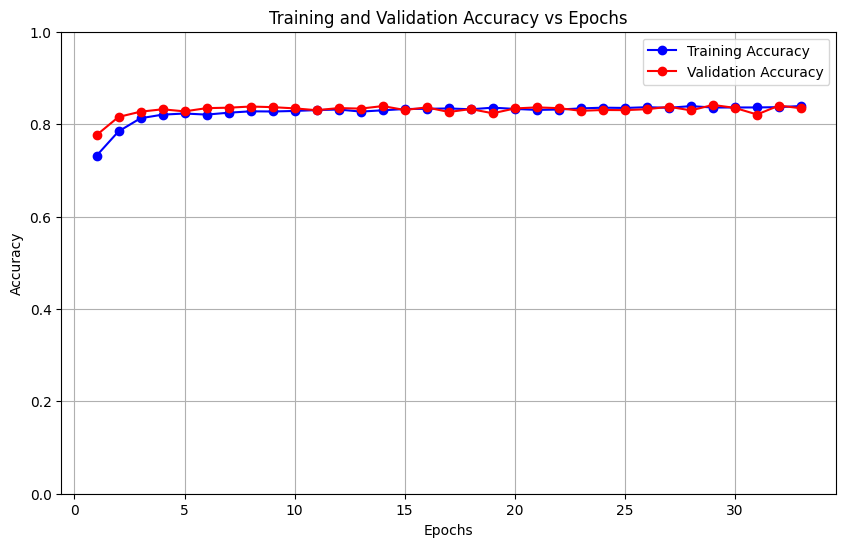

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, marker='o', color='blue', label="Training Accuracy")
plt.plot(epochs, val_accuracies, marker='o', color='red', label="Validation Accuracy")

plt.title("Training and Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.show()

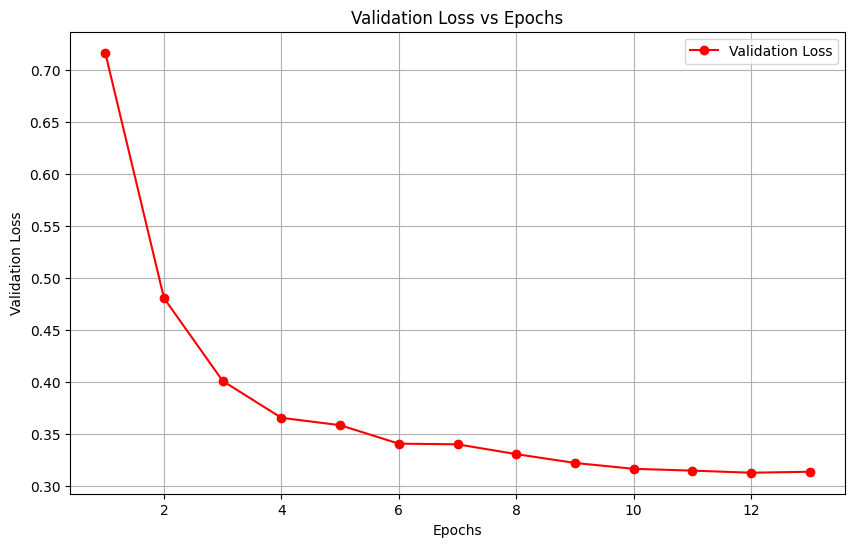

In [ ]:
# Plot validation loss for personal use
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_losses, marker='o', color='red', label="Validation Loss")
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Exercise 2 - Network 2

Importing necessary libraries

In [84]:
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt

Downloaded the required data, and transformed the images for a data type which is suitable for inserting in PyTorch tensors.
Split the training data (60,000) to 56,000 samples for training and 4000 for valiation.


In [85]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(f'Train Dataset Size: {len(train_dataset)}')
print(f'Test Dataset Size: {len(test_dataset)}')

train_dataset, val_dataset = random_split(train_dataset, [56000, 4000])

test_loader = DataLoader(test_dataset, shuffle=False)
train_loader = DataLoader(train_dataset,batch_size = 2000, shuffle=True) # Splitting the training data for batches of 2000 samples.

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 326kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.73MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.3MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train Dataset Size: 60000
Test Dataset Size: 10000


Built a 4-Layer NN as required, with an input size of 784, since our pictures are of dims 28x28 with size 10 in the output layer.
In every layer, used ReLU activation function, as it is simple, fast and avoid vanishing gradient and widely used in classification tasks.

In [86]:
class FashionMNST(nn.Module):
    def __init__(self, input_size):
        super(FashionMNST, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32, 10)
        #self.fc4 = nn.Linear(16,10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.fc4(x)
        return x

model = FashionMNST(input_size=784)
print(model)

FashionMNST(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


Layer 1: nn.Linear(input_size, 70)

Weights:
784 × 64 = 50,176

Biases: 64

Total Parameters for Layer 1:

50,175 + 64 = 50,240

---

Layer 2: nn.Linear(64, 32)

Weights:
64 × 32 = 2,048

Biases: 32

Total parameters for Layer 2: 2,048 + 32 = 2,080

---
Layer 3: nn.Linear(32, 10)

Weights:
32 × 10 = 320

Biases: 10

Total parameters for Layer 3: 320 + 10 = 330


**Total Parameters=50,240 + 2,080 + 330 = 52,650**


* Used CrossEntropyLoss as the loss function because it is the most appropriate loss function for multi-class classification. While others might work but this worked best with our problem.
* As mentioned earlier, since our images are of dims 28x28 the input size of our network is 784
* Used Adam optimizer with a learning rate of 0.001 as it involves the optimization of several deep learning optimizers like SGD, RMSProp.
Tested over several learning rates and this achieved the best.

In [87]:
loss_values = [] # Used to store loss values to plot.
train_accuracies = [] # Used to store training accuracy to plot.
val_accuracies = [] # Used to store validation accuracy to plot.
val_losses = [] # For personal plotting and testing.

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) # Validation data loader.

num_epochs = len(train_loader) + 5  # Training for over 33 Epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    running_loss = 0.0 # For calculating avg loss.

    # Training loop
    for images, labels in train_loader:

        images = images.view(images.size(0), -1) # Flatten the images

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad() # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)  # Append training accuracy
    loss_values.append(running_loss / len(train_loader))  # Average loss per batch

    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0


    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.view(val_images.size(0), -1)  # Flatten the images

            # Forward pass for validation
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)

            # Calculate validation predictions
            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()
            val_running_loss += val_loss.item()

    # Calculate validation accuracy and loss for the epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(val_running_loss / len(val_loader))  # Average validation loss per batch

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {loss_values[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Create a DataLoader for the validation dataset

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)  # Flatten the images if needed

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class

        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')

Epoch [1/33], Train Loss: 1.8230, Train Accuracy: 0.3822, Val Loss: 1.2437, Val Accuracy: 0.6245
Epoch [2/33], Train Loss: 0.9559, Train Accuracy: 0.6827, Val Loss: 0.7685, Val Accuracy: 0.7310
Epoch [3/33], Train Loss: 0.7003, Train Accuracy: 0.7492, Val Loss: 0.6435, Val Accuracy: 0.7817
Epoch [4/33], Train Loss: 0.6049, Train Accuracy: 0.7906, Val Loss: 0.5755, Val Accuracy: 0.7997
Epoch [5/33], Train Loss: 0.5481, Train Accuracy: 0.8102, Val Loss: 0.5274, Val Accuracy: 0.8203
Epoch [6/33], Train Loss: 0.5120, Train Accuracy: 0.8233, Val Loss: 0.5029, Val Accuracy: 0.8270
Epoch [7/33], Train Loss: 0.4849, Train Accuracy: 0.8331, Val Loss: 0.4815, Val Accuracy: 0.8365
Epoch [8/33], Train Loss: 0.4636, Train Accuracy: 0.8396, Val Loss: 0.4595, Val Accuracy: 0.8423
Epoch [9/33], Train Loss: 0.4466, Train Accuracy: 0.8456, Val Loss: 0.4455, Val Accuracy: 0.8460
Epoch [10/33], Train Loss: 0.4323, Train Accuracy: 0.8496, Val Loss: 0.4367, Val Accuracy: 0.8485
Epoch [11/33], Train Loss: 0.

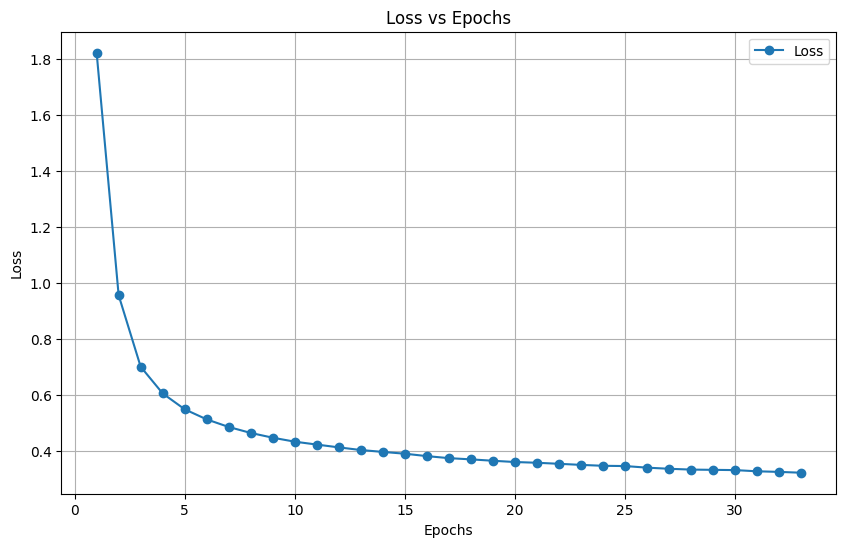

In [90]:
epochs = range(1, len(loss_values) + 1)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', label="Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

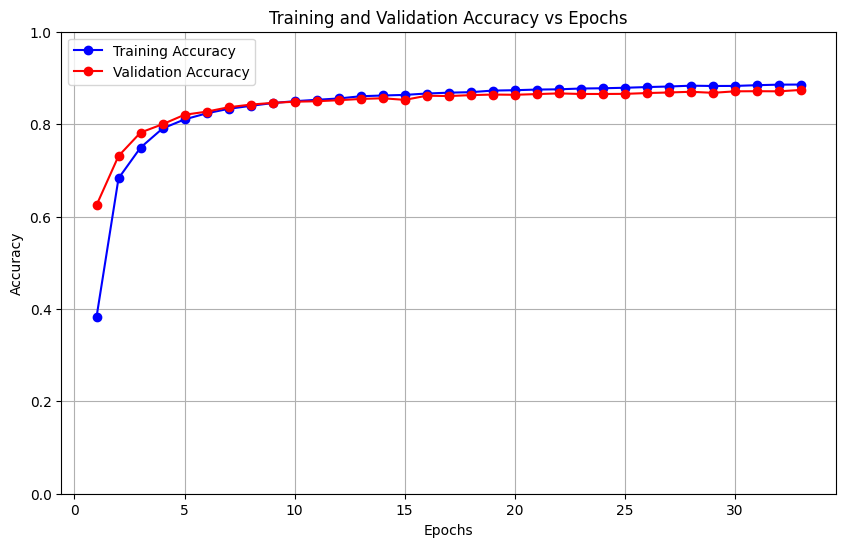

In [91]:
epochs = range(1, len(val_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, marker='o', color='blue', label="Training Accuracy")
plt.plot(epochs, val_accuracies, marker='o', color='red', label="Validation Accuracy")

plt.title("Training and Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.show()

## Networks Comparison
**Introduction**

Network 1 simplifies the learning problem, reducing complexity and allowing the network to perform well despite being shallow and simple.
Overfitting is less likely due to the lower complexity of the model and the smaller dataset.
However, this network cannot generalize well to more complex tasks, such as recognizing all 10 classes, due to its simplicity as fewer parameters are required to learn the decision boundaries.


Network 2 has a larger architecture which allows to learn complex relationships needed for 10 classes. However, this also increases the risk of overfitting
Needs careful training to avoid vanishing or exploding gradients.
Training on all 10 classes introduces more complexity, making the task harder compared to training on 4 classes as more parameters requires more complex computations.

---

**Parameters**

It's obvious why the input layer and output layer's parameters are like that.

**Network 1**

Adam Learning Rate: 0.001
A standard learning rate that balances training speed and stability, a larger value resulted in Exploding Gradient and Divergence.

Batch Size: 1500
A relatively large batch size that improves stability but reduces the frequency of updates, which can limit the model’s ability to converge effectively, a larger batch size resulted in worse accuracy and a small batch size resulted in loss of generality and accuracy.

Number of Epochs: 13
Fewer epochs reduce the total training time but may result in underfitting for more complex tasks, a much larger Epochs resulted in overfitting.

**Network 2**


Layer 1: nn.Linear(784, 64)

This first layer captures all features (pixels) from the input, creating a high-dimensional representation.

Layer 2: nn.Linear(64, 32)
Reduces the feature dimensions, focusing on the most important information from the first layer.

Layer 3: nn.Linear(32, 10)
Further compresses the feature space, which may risk losing some critical information if the network is not trained properly.


Larger layers resulted in capturing features that are not important for the classification while smaller layers gave up features that we're crucial for the classification task.

Adam Learning Rate: 0.001

A standard learning rate that prevents unstable updates. However, in deeper networks, slightly lower rates may improve convergence. **Also Same as mentioned in Network 1.**

Batch Size: 2000
A larger batch size stabilizes training but reduces the frequency of parameter updates. For a deeper network, this might hinder convergence.**Also Same as mentioned in Network 1.**

Number of Epochs: 33
Training for more epochs allows the network to converge better, but it increases the risk of overfitting, especially for smaller datasets.
**Also Same as mentioned in Network 1.**

Performance:
Achieves an accuracy of 84%, which is lower than Network 1. The deeper architecture and more complex task (10 classes) make training harder, especially without additional regularization techniques.

---
---

***Overall Performance Difference***

Why Network 1 Performed Better than Network 2

**Simpler Task: 4 Classes vs. 10 Classes**


Network 1 was designed to classify only 4 classes, making the task inherently simpler. With fewer classes, the decision boundaries required to separate them in the feature space are less complex, allowing the network to learn and generalize more easily.

Network 2, on the other hand, had to classify 10 classes, which introduces significantly more complexity. The decision boundaries in the feature space become more intricate, increasing the likelihood of overlapping features between classes and misclassifications. This higher complexity makes it harder for the network to achieve the same level of accuracy.


**Less Layers vs. More Layers**


Network 1 had a single layer (nn.Linear(784, 4)), which is sufficient for capturing the basic patterns needed to separate 4 classes. With fewer layers, the network focuses on simpler representations without overcomplicating the learning process.

Network 2 had 4 layers (nn.Linear(784, 70), nn.Linear(70, 32), nn.Linear(32, 16), and nn.Linear(16, 10)), allowing it to capture more detailed and hierarchical features. While this depth is advantageous for complex problems, it introduces challenges:
The network needs to learn many intermediate representations, which can lead to a loss of key information or overfitting to specific patterns in the data.
Compressing features aggressively in later layers (e.g., reducing from 32 → 16 → 10) can also limit the network’s ability to preserve important information, affecting accuracy.


**More Parameters and Training Requirements**


Network 1 had only 3,140 parameters, making it much easier to optimize. With fewer parameters, the optimization process converges faster, requiring less data and fewer epochs to achieve high performance.
Network 2, with 52,650 parameters, required significantly more training to optimize its larger parameter space. This large number of parameters increases the risk of overfitting without sufficient training data or proper regularization. Additionally:
The increased depth and parameter count make it harder for the optimization algorithm to find a globally optimal solution.
More parameters mean that the model requires more epochs and finer hyperparameter tuning to converge effectively.


**Training Stability**


The simpler architecture and fewer parameters in Network 1 make it less sensitive to hyperparameter choices (e.g., learning rate, batch size). It trains quickly and reaches high accuracy with minimal risk of overfitting.
Network 2, due to its depth and complexity, is more sensitive to hyperparameters. Suboptimal choices (e.g., larger batch sizes or insufficient regularization) can lead to slower convergence, overfitting, or underfitting, impacting its performance.


**Note**


Its quite important to note that Network 2’s deeper architecture and increased number of layers make it better suited for complex tasks like 10-class classification. However, since it was mandatory that the network's parameters does not pass 60K without proper regularization and hyperparameter tuning, the network struggles to generalize well. In contrast, Network 1 performs better due to its simplicity and a less challenging task.






